<a href="https://colab.research.google.com/github/PriyaSinha786/research-papers/blob/main/CDIPR/hr_poc_colab_v4_openai_only_KG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HR POC v4 — OpenAI-first (no SBERT/hf-hub pin)

This notebook prefers OpenAI embeddings and ChatCompletion (if you provide an API key). It **does not** install `sentence-transformers` or pin `huggingface-hub`, avoiding the package conflicts you encountered in Colab. If you do not provide a key it falls back to TF-IDF retrieval.

Run cells in order. If you change packages, restart the runtime.

In [1]:
!pip install -q --upgrade openai scikit-learn pandas joblib networkx matplotlib
print('Installed/updated minimal packages (openai, sklearn, pandas, joblib, networkx, matplotlib).')

Installed/updated minimal packages (openai, sklearn, pandas, joblib, networkx, matplotlib).


In [2]:
# Diagnostic check for openai shadowing and environment
import os, sys
print('cwd:', os.getcwd())
print('files in cwd:', [f for f in os.listdir('.')][:50])
try:
    import openai
    print('openai module path:', getattr(openai, '__file__', None))
    print('openai dir contains:', [k for k in dir(openai) if 'emb' in k.lower() or 'Emb' in k])
except Exception as e:
    print('openai import error:', e)


cwd: /content
files in cwd: ['.config', 'sample_data']
openai module path: /usr/local/lib/python3.12/dist-packages/openai/__init__.py
openai dir contains: ['Embedding', 'embeddings']


In [3]:
from getpass import getpass
import os
key = getpass('Enter your OpenAI API key (leave blank to skip): ')
if key:
    os.environ['OPENAI_API_KEY'] = key
    print('OPENAI_API_KEY set in environment')
else:
    print('No key provided. Notebook will use TF-IDF fallback for retrieval.')

Enter your OpenAI API key (leave blank to skip): ··········
OPENAI_API_KEY set in environment


In [4]:
# Prepare data (resumes, JDs, policies, attrition CSV)
import os, random, json
from pathlib import Path
import pandas as pd
random.seed(42)
BASE = Path('/content/hr_poc_openai')
DATA = BASE / 'data'
RES = DATA / 'resumes'
JDS = DATA / 'jds'
POL = DATA / 'policy_docs'
MODELS = BASE / 'models'
OUT = BASE / 'output'
for p in [DATA, RES, JDS, POL, MODELS, OUT]:
    p.mkdir(parents=True, exist_ok=True)

# Attrition CSV
rows = []
for i in range(500):
    age = random.randint(22,60)
    monthly_income = random.randint(2000,20000)
    job_sat = random.choice([1,2,3,4])
    years = random.randint(0,30)
    gender = random.choice(['Male','Female'])
    education = random.choice([1,2,3,4,5])
    prob_attr = 0.2
    if age < 30 and job_sat <= 2 and years < 3:
        prob_attr = 0.6
    attrition = 1 if random.random() < prob_attr else 0
    rows.append([age, monthly_income, job_sat, years, gender, education, attrition])
df = pd.DataFrame(rows, columns=['Age','MonthlyIncome','JobSatisfaction','YearsAtCompany','Gender','Education','Attrition'])
df.to_csv(DATA/'attrition_synthetic.csv', index=False)
print('Wrote attrition CSV to', DATA/'attrition_synthetic.csv')

# Create resumes
skills_pool = ['Python','Java','SQL','Machine Learning','Deep Learning','NLP','Computer Vision','Data Engineering','TensorFlow','PyTorch','Kubernetes','AWS','Docker','Communication','Leadership','UX Design','Figma','React','Sales','SEO','Google Analytics','Recruiting','Interviewing','Payroll','Testing']
roles = ['Data Scientist','ML Engineer','Backend Developer','DevOps Engineer','Product Manager','QA Engineer','UX Designer','Sales Executive','Marketing Specialist','HR Specialist']
for i in range(1,81):
    name = f'Candidate_{i}'
    role = roles[i % len(roles)]
    if i % 8 == 0:
        skills = random.sample([s for s in skills_pool if s not in ['Python','Machine Learning','SQL','TensorFlow','PyTorch']], k=random.randint(2,5))
    else:
        if 'Data' in role or 'ML' in role:
            core = ['Python','SQL','Machine Learning','TensorFlow','PyTorch']
        elif 'Backend' in role or 'DevOps' in role:
            core = ['Java','Kubernetes','Docker','AWS','SQL']
        elif 'Product' in role:
            core = ['Communication','Leadership','React']
        elif 'QA' in role:
            core = ['Testing','Python','Java']
        elif 'UX' in role:
            core = ['UX Design','Figma','Communication']
        elif 'Sales' in role or 'Marketing' in role:
            core = ['Sales','SEO','Google Analytics','Communication']
        elif 'HR' in role:
            core = ['Recruiting','Interviewing','Payroll','Communication']
        skills = list(set(random.sample(core, k=max(1,min(len(core),2))) + random.sample(skills_pool, k=random.randint(1,3))))
    years = random.randint(0,12)
    exp = f'I worked as a {role} for {years} years. I have experience in ' + ', '.join(skills) + '.'
    resume_text = f'{name}\n{role}\n{exp}\nResponsibilities: Delivered projects.'
    (RES/f'resume_{i}.txt').write_text(resume_text)
print('Wrote resumes to', RES)

# JDs
jds = {
    'JD_Data_Scientist.txt': 'Looking for a Data Scientist with Python, SQL, Machine Learning and TensorFlow or PyTorch.',
    'JD_Backend_Developer.txt': 'Seeking Backend Developer experienced in Java, SQL, Docker, and AWS.',
    'JD_DevOps_Engineer.txt': 'DevOps Engineer with Kubernetes, Docker, AWS, and CI/CD automation.',
    'JD_UX_Designer.txt': 'UX Designer with Figma, user research and prototyping experience.',
    'JD_HR_Specialist.txt': 'HR Specialist experienced in recruiting, interviewing, payroll systems.'
}
for fn, txt in jds.items():
    (JDS/fn).write_text(txt)
print('Wrote JDs to', JDS)

# Policies
policies = {
    'policy_1.txt': 'Equal Opportunity Policy: assess candidates on skills and experience.',
    'policy_2.txt': 'Data Privacy Policy: Candidate personal data must be handled per local laws. Do not expose PII.',
    'policy_3.txt': 'Promotion Eligibility: Minimum 2 years in role and demonstrable impact.',
    'policy_4.txt': 'Interview Feedback Policy: notes must be factual.'
}
for fn, txt in policies.items():
    (POL/fn).write_text(txt)
print('Wrote policies to', POL)

# Save config
config = {'resumes_dir': str(RES), 'jds_dir': str(JDS), 'policies_dir': str(POL), 'attrition_csv': str(DATA/'attrition_synthetic.csv')}
(DATA/'config.json').write_text(json.dumps(config, indent=2))
print('Wrote config.json')

Wrote attrition CSV to /content/hr_poc_openai/data/attrition_synthetic.csv
Wrote resumes to /content/hr_poc_openai/data/resumes
Wrote JDs to /content/hr_poc_openai/data/jds
Wrote policies to /content/hr_poc_openai/data/policy_docs
Wrote config.json


In [5]:
# Build index: prefer OpenAI embeddings (modern client). If no key or OpenAI call fails, fall back to TF-IDF.
import os, joblib, json
from pathlib import Path
import numpy as np
BASE = Path('/content/hr_poc_openai')
DATA = BASE / 'data'
RES = DATA / 'resumes'
JDS = DATA / 'jds'
POL = DATA / 'policy_docs'
MODELS = BASE / 'models'
MODELS.mkdir(parents=True, exist_ok=True)

corpus = []; meta = []
for p in sorted(RES.glob('*.txt')): corpus.append(p.read_text()); meta.append({'source':str(p),'type':'resume'})
for p in sorted(JDS.glob('*.txt')): corpus.append(p.read_text()); meta.append({'source':str(p),'type':'jd'})
for p in sorted(POL.glob('*.txt')): corpus.append(p.read_text()); meta.append({'source':str(p),'type':'policy'})
print('Corpus size:', len(corpus))

use_openai = bool(os.environ.get('OPENAI_API_KEY'))
if use_openai:
    try:
        from openai import OpenAI
        client = OpenAI(api_key=os.environ.get('OPENAI_API_KEY'))
        emb_model = 'text-embedding-3-small'
        print('Creating OpenAI embeddings with', emb_model)
        all_embs = []
        B = 50
        for i in range(0, len(corpus), B):
            batch = corpus[i:i+B]
            resp = client.embeddings.create(model=emb_model, input=batch)
            batch_embs = [d.embedding for d in resp.data]
            all_embs.extend(batch_embs)
        embs = np.array(all_embs)
        joblib.dump({'embeddings':embs, 'docs':corpus, 'meta':meta, 'method':'openai', 'model':emb_model}, MODELS/'doc_index_openai.joblib')
        print('Saved OpenAI index to', MODELS/'doc_index_openai.joblib')
    except Exception as e:
        print('OpenAI embeddings failed:', e)
        use_openai = False

if not use_openai:
    print('Using TF-IDF fallback (no OpenAI key or embeddings failed)')
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.neighbors import NearestNeighbors
    vec = TfidfVectorizer(max_features=4000)
    X = vec.fit_transform(corpus)
    nn = NearestNeighbors(n_neighbors=6, metric='cosine').fit(X)
    joblib.dump({'vectorizer':vec, 'nn':nn, 'docs':corpus, 'meta':meta, 'method':'tfidf'}, MODELS/'doc_index_tfidf.joblib')
    print('Saved TF-IDF index to', MODELS/'doc_index_tfidf.joblib')

Corpus size: 89
Creating OpenAI embeddings with text-embedding-3-small
Saved OpenAI index to /content/hr_poc_openai/models/doc_index_openai.joblib


In [6]:
# RAG retrieval and answer (OpenAI ChatCompletion if key present, else simple template).
import os, joblib, numpy as np
from pathlib import Path
BASE = Path('/content/hr_poc_openai')
MODELS = BASE / 'models'
DATA = BASE / 'data'
RES = DATA / 'resumes'
OUT = BASE / 'output'
OUT.mkdir(parents=True, exist_ok=True)

# Load index helper
def load_index():
    if (MODELS/'doc_index_openai.joblib').exists():
        return joblib.load(MODELS/'doc_index_openai.joblib')
    if (MODELS/'doc_index_tfidf.joblib').exists():
        return joblib.load(MODELS/'doc_index_tfidf.joblib')
    raise FileNotFoundError('No index found. Run index cell.')

idx = load_index()
method = idx.get('method')
from numpy.linalg import norm

def retrieve_topk(query_text, topk=3):
    docs = idx['docs']; meta = idx['meta']
    if method == 'openai':
        try:
            from openai import OpenAI
            client = OpenAI(api_key=os.environ.get('OPENAI_API_KEY'))
            q_emb = np.array(client.embeddings.create(model=idx.get('model','text-embedding-3-small'), input=[query_text]).data[0].embedding)
        except Exception as e:
            print('Query encode failed (OpenAI):', e); return []
        embs = np.array(idx['embeddings'])
        scores = (embs @ q_emb) / ((norm(embs, axis=1) * norm(q_emb)) + 1e-8)
        ids = list(scores.argsort()[-topk:][::-1])
        return [{'score': float(scores[i]), 'text': docs[i], 'meta': meta[i]} for i in ids]
    else:
        vec = idx['vectorizer']; nn = idx['nn']
        qv = vec.transform([query_text])
        dists, ids = nn.kneighbors(qv, n_neighbors=topk)
        return [{'score': float(1-d), 'text': idx['docs'][i], 'meta': idx['meta'][i]} for i,d,i in zip(ids[0], dists[0], ids[0])]

def rag_answer(resume_text, topk=3):
    retrieved = retrieve_topk(resume_text, topk=topk)
    print('\nTop retrieved docs:')
    for r in retrieved:
        print('-', Path(r['meta']['source']).name, f'(score={r["score"]:.3f})')
    sources = [r['meta']['source'] for r in retrieved]
    context = ''
    for i,r in enumerate(retrieved):
        snippet = r['text'][:800]
        context += f'[DOC_{i}] {Path(r["meta"]["source"]).name}\n{snippet}\n\n'
    answer = None
    if os.environ.get('OPENAI_API_KEY'):
        try:
            from openai import OpenAI
            client = OpenAI(api_key=os.environ.get('OPENAI_API_KEY'))
            system = 'You are an HR governance assistant. Use the retrieved passages and always cite filenames like [DOC_0].'
            prompt = f'Resume:\n{resume_text}\n\nRetrieved documents:\n{context}\n\nTask: Provide a 2-3 sentence recommendation (HIRE / NO HIRE / CONSIDER), justify it, and cite sources as [DOC_i].'
            resp = client.chat.completions.create(model='gpt-4o-mini', messages=[{'role':'system','content':system},{'role':'user','content':prompt}], max_tokens=300)
            answer = resp.choices[0].message.content
        except Exception as e:
            print('OpenAI chat failed:', e)
            answer = None
    if not answer:
        text = resume_text.lower()
        if 'machine learning' in text or 'data' in text or 'ml' in text:
            rec = 'Consider for Data/ML role — strong relevant skills.'
        else:
            rec = 'Consider with caution — insufficient domain-specific skills.'
        reasons = 'Recommendation based on skills and policy.'
        cited = ', '.join([Path(s).name for s in sources])
        answer = f'Recommendation: {rec}\nReasons: {reasons}\nCited sources: {cited}'
    # audit log
    import json, time
    log = {'query': resume_text[:200], 'retrieved':[Path(s).name for s in sources], 'answer': answer.splitlines()[0], 'ts': time.strftime('%Y-%m-%d %H:%M:%S')}
    (OUT/'rag_responses.json').write_text(json.dumps(log, indent=2))
    print('\nAnswer:\n', answer)

# Demo on first 6 resumes
for p in sorted(RES.glob('*.txt'))[:6]:
    print('\n====', p.name, '====')
    rtext = p.read_text()
    print(rag_answer(rtext, topk=3))


==== resume_1.txt ====

Top retrieved docs:
- resume_1.txt (score=1.000)
- resume_11.txt (score=0.888)
- resume_51.txt (score=0.871)

Answer:
 Recommendation: NO HIRE. While Candidate_1 possesses valuable skills in Deep Learning and has experience with relevant technologies, their lack of professional experience as an ML Engineer (0 years) compared to other candidates with more extensive experience, such as Candidate_51 with 9 years in the field [DOC_2], makes them less competitive for this role.
None

==== resume_10.txt ====

Top retrieved docs:
- resume_10.txt (score=1.000)
- resume_30.txt (score=0.840)
- resume_20.txt (score=0.837)

Answer:
 Recommendation: CONSIDER. Candidate_10 has solid experience as a Data Scientist, with 6 years in the field and a diverse skill set that includes Docker, Figma, and PyTorch. However, other candidates, such as Candidate_30, possess more extensive experience (12 years) and a broader range of relevant tools including Machine Learning and TensorFlow

## Notes

- This notebook avoids changing `huggingface-hub` and `sentence-transformers` to prevent dependency conflicts with Gradio/Transformers/Diffusers that may be preinstalled in Colab. It uses OpenAI embeddings if you set `OPENAI_API_KEY`, otherwise falls back to TF-IDF retrieval.
- Running OpenAI embedding & chat calls consumes credits — use the smaller embedding model and limit corpus size if experimenting.
- After you run the install cell, if you make any package changes, restart the runtime (Runtime → Restart runtime) before continuing.

Artifacts will be under `/content/hr_poc_openai/output/` and indexes in `/content/hr_poc_openai/models/`.

# Knowledge-Graph Visualization of RAG Retrievals

This section builds a small knowledge graph that includes resumes, skills, roles, JDs, and policy documents. It adds retrieval edges from each resume to its top-k retrieved documents and visualizes the local neighborhood for a few example resumes. Run the cell after you have already built the document index in the notebook (i.e., run the index cell first).

Index method: openai
Built KG with nodes: 124 edges: 732
Saved KG visualization to /content/hr_poc_openai/output/kg_resume_67.png


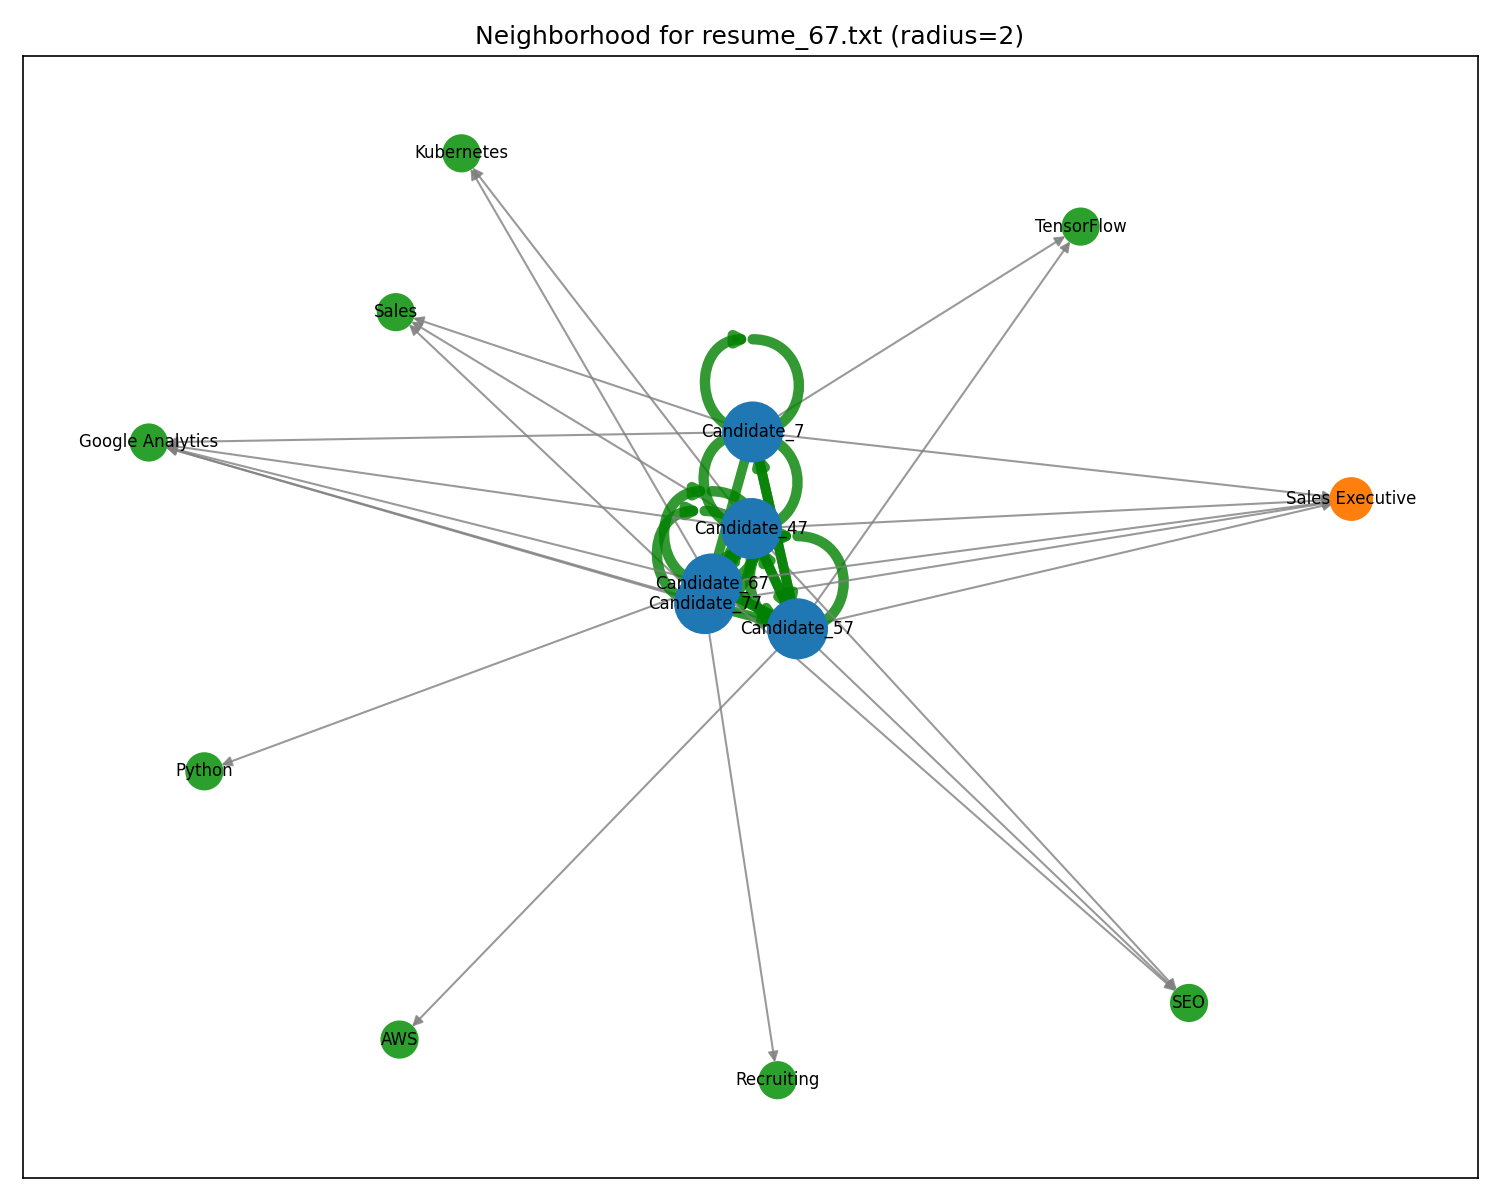

Saved KG visualization to /content/hr_poc_openai/output/kg_resume_57.png


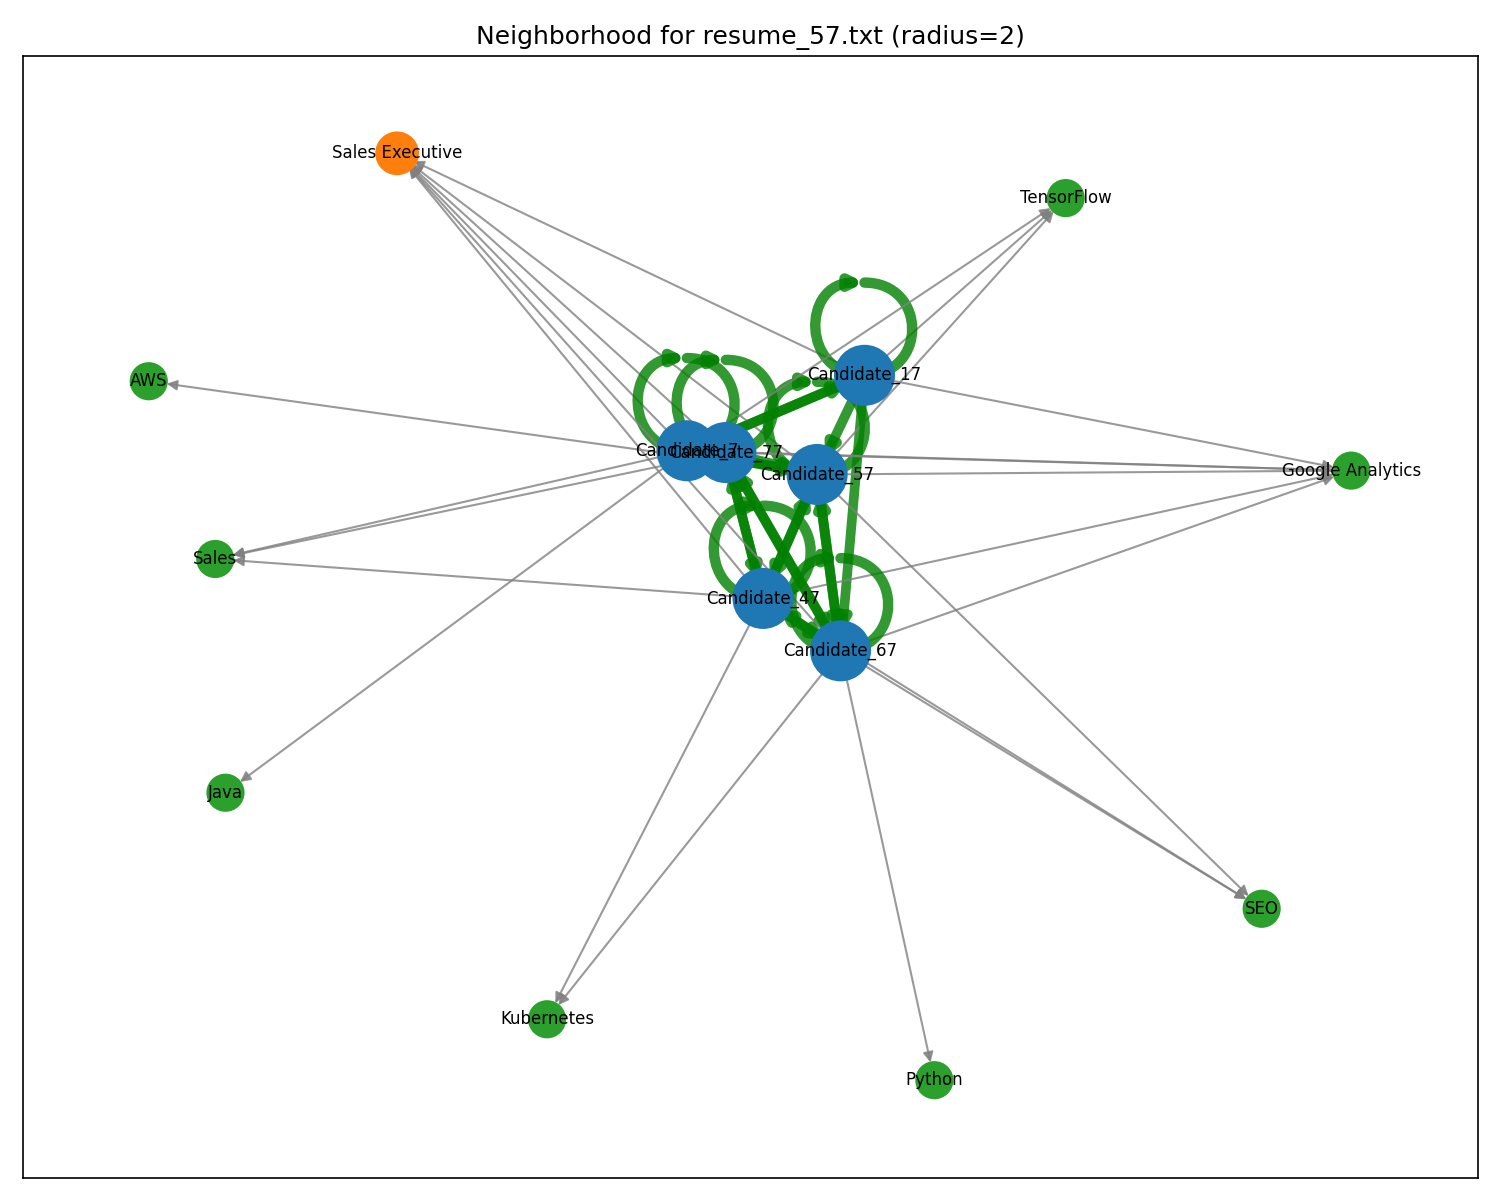

Saved KG visualization to /content/hr_poc_openai/output/kg_resume_47.png


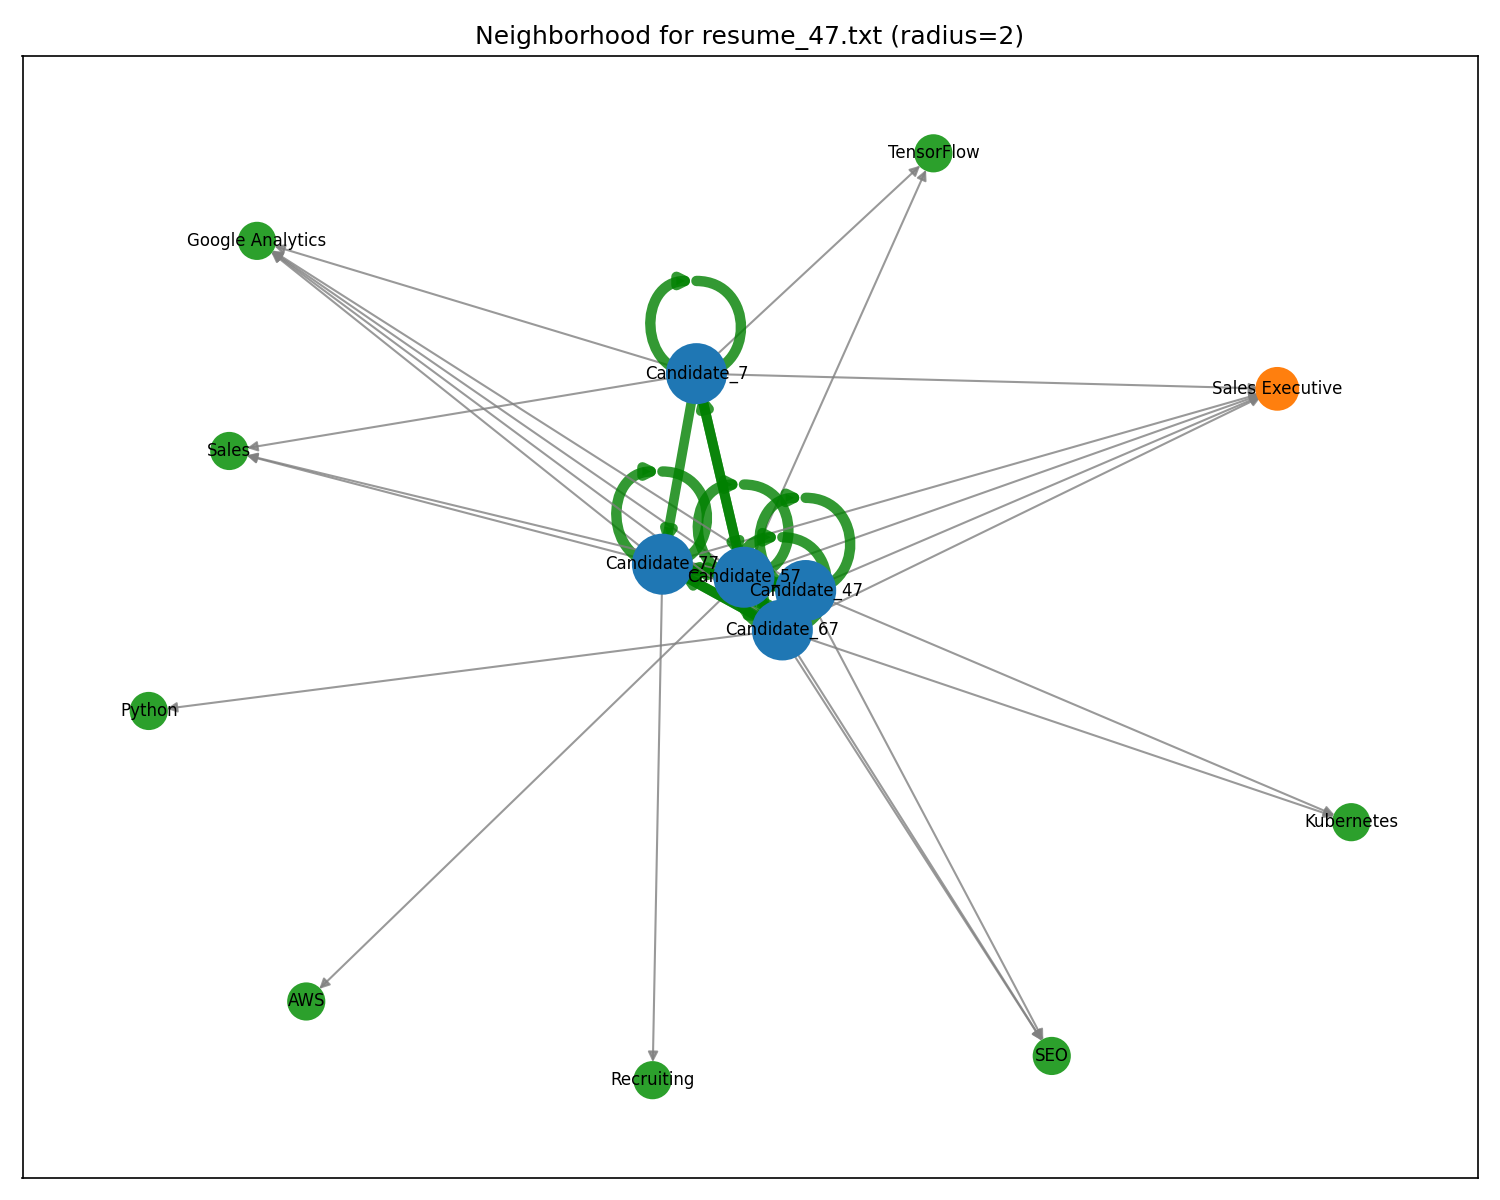

Saved KG visualization to /content/hr_poc_openai/output/kg_resume_27.png


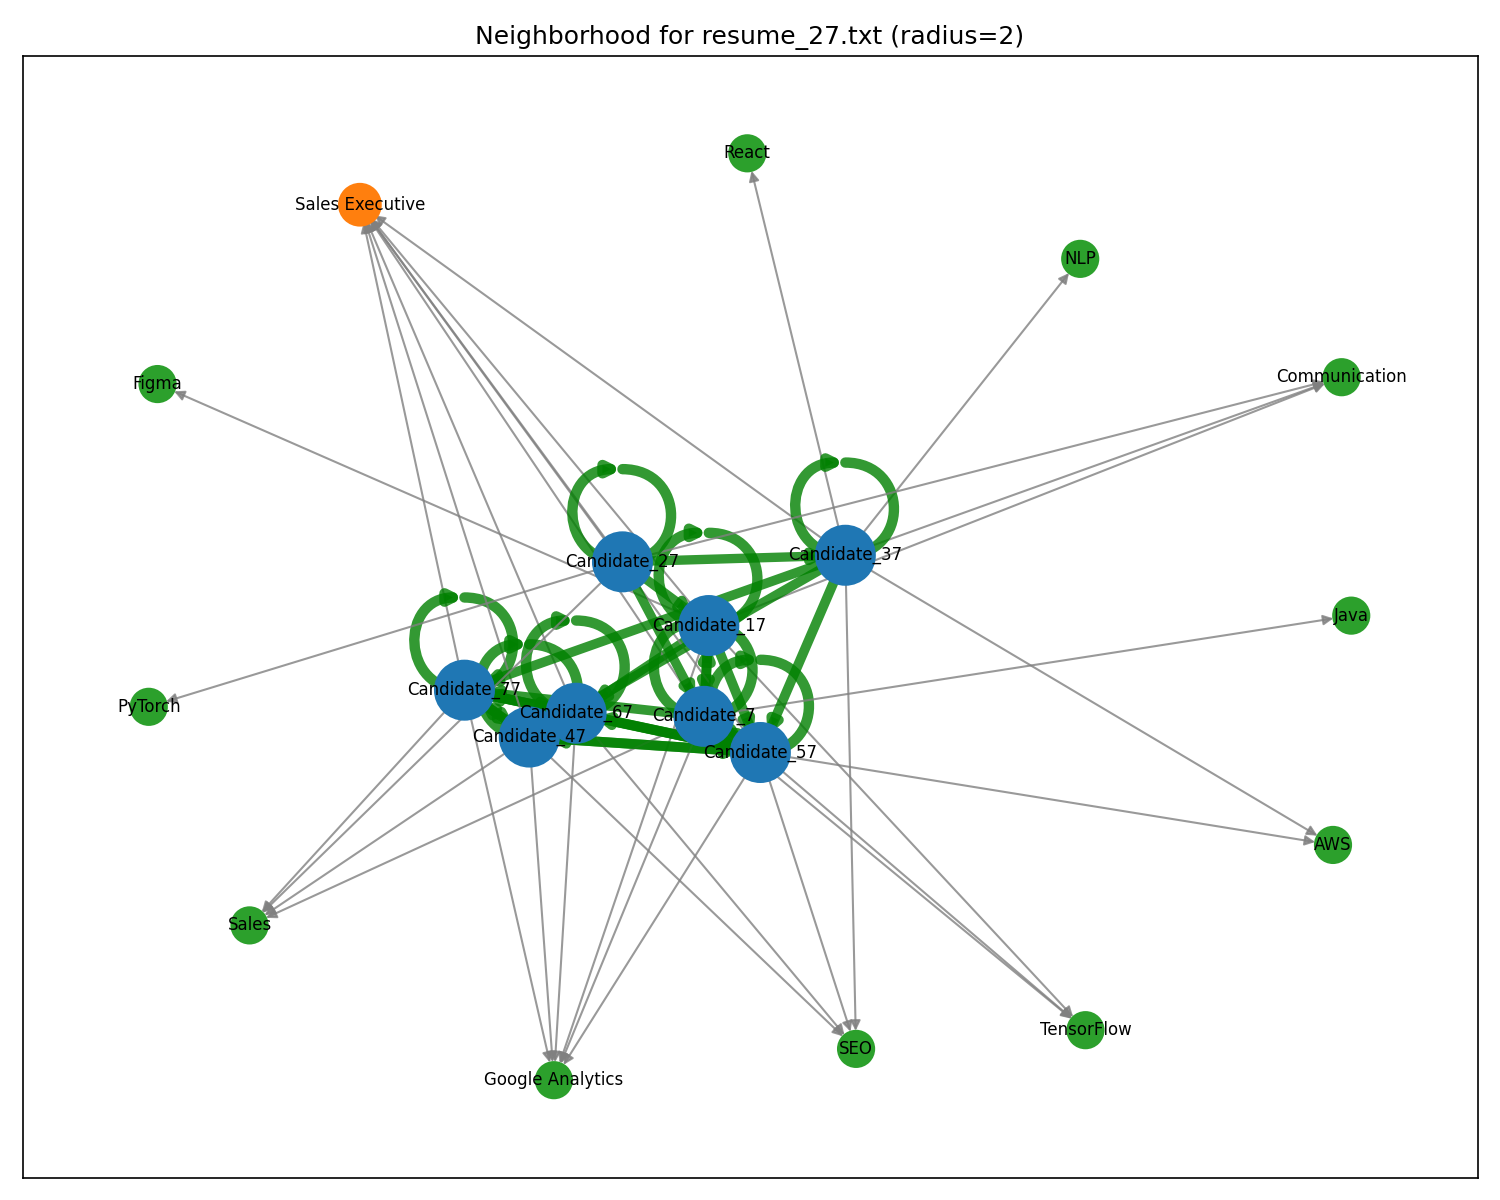

Saved KG visualization to /content/hr_poc_openai/output/kg_resume_69.png


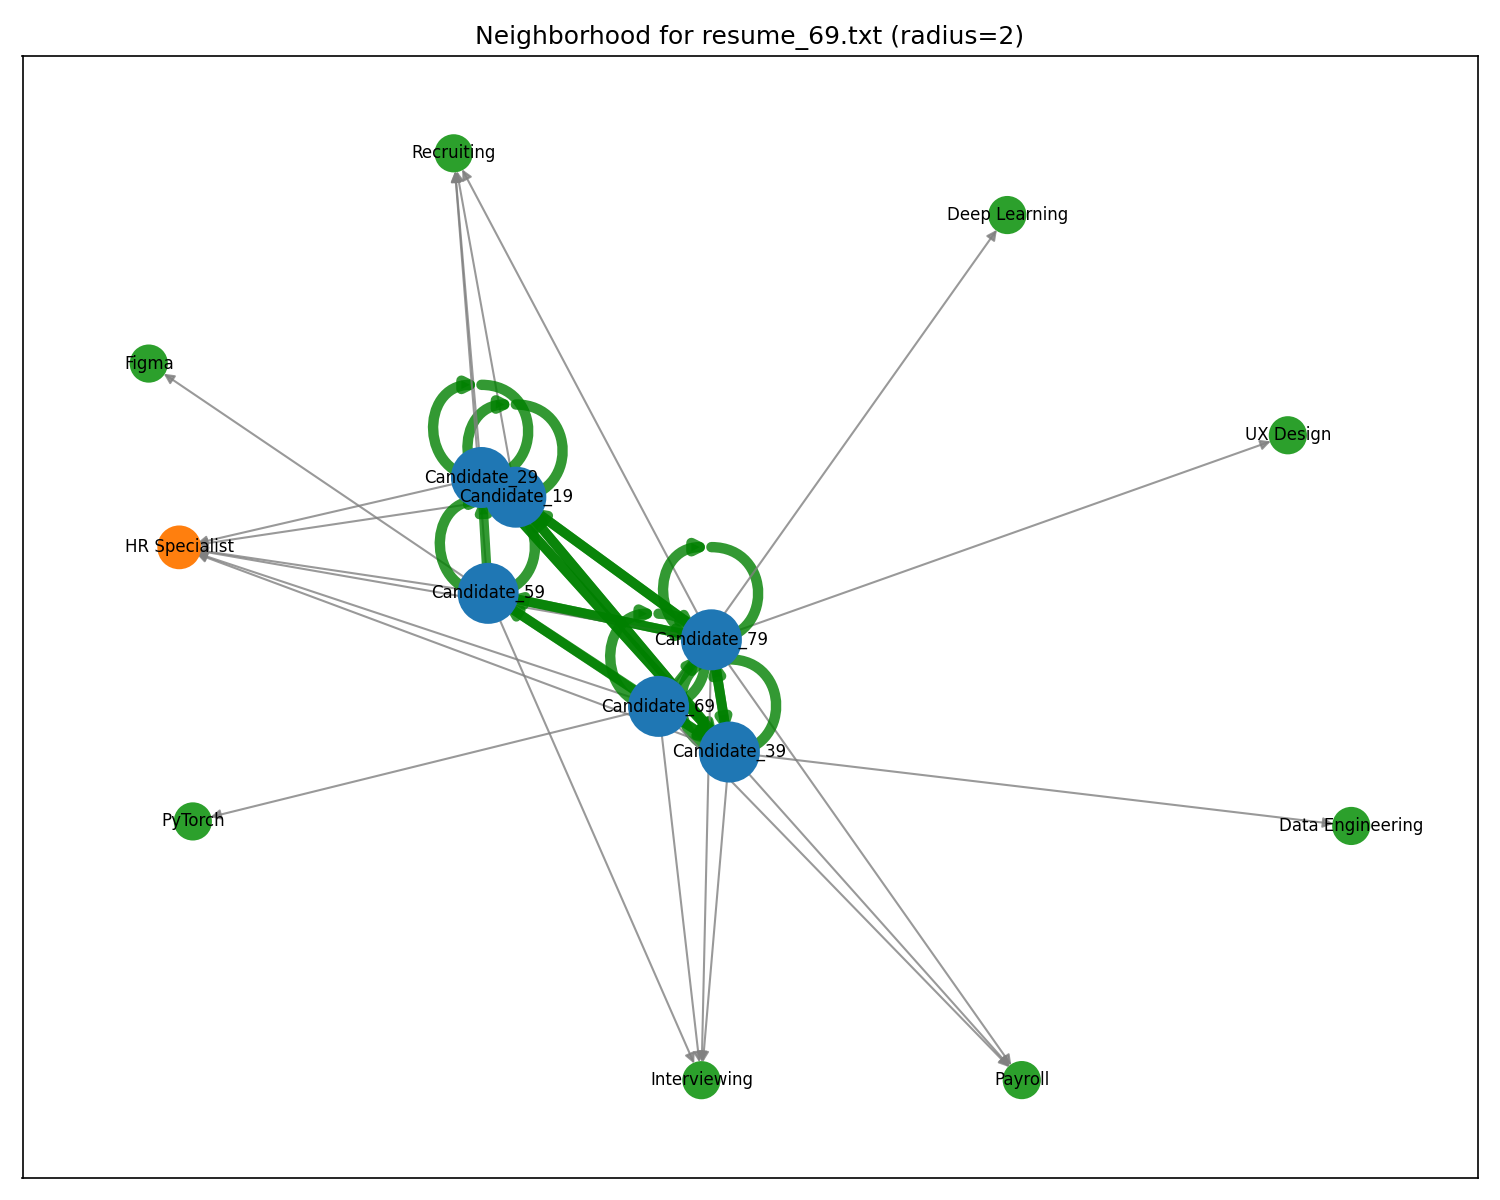

Saved KG visualization to /content/hr_poc_openai/output/kg_resume_64.png


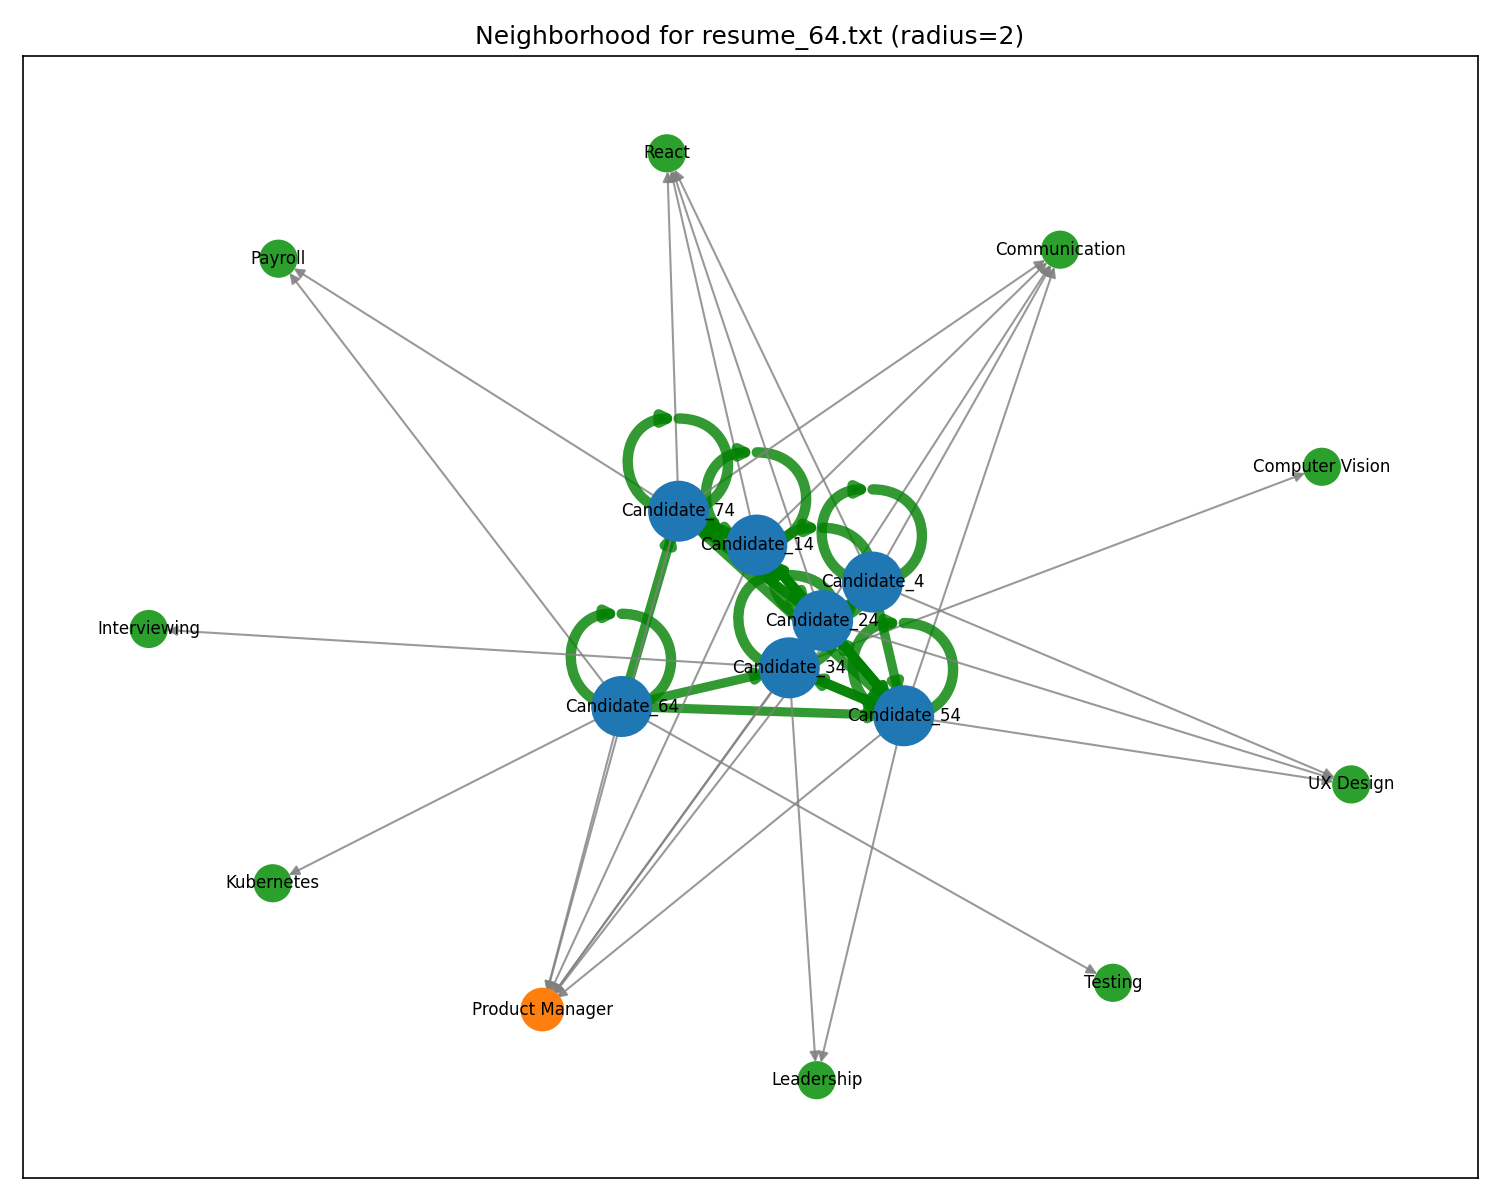

Created KG visualizations for examples: ['/content/hr_poc_openai/output/kg_resume_67.png', '/content/hr_poc_openai/output/kg_resume_57.png', '/content/hr_poc_openai/output/kg_resume_47.png', '/content/hr_poc_openai/output/kg_resume_27.png', '/content/hr_poc_openai/output/kg_resume_69.png', '/content/hr_poc_openai/output/kg_resume_64.png']
Saved all_retrievals.joblib to /content/hr_poc_openai/output


In [7]:
# KG visualization: load index, build KG, add retrieval edges, and visualize neighborhoods.
# Run this cell after you've built the index (OpenAI embeddings or TF-IDF).
import joblib, json, math, random
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

BASE = Path('/content/hr_poc_openai')
DATA = BASE / 'data'
RES = DATA / 'resumes'
JDS = DATA / 'jds'
POL = DATA / 'policy_docs'
MODELS = BASE / 'models'
OUT = BASE / 'output'
OUT.mkdir(parents=True, exist_ok=True)

# Load index (prefer openai, then tfidf)
def load_index():
    if (MODELS/'doc_index_openai.joblib').exists():
        return joblib.load(MODELS/'doc_index_openai.joblib')
    if (MODELS/'doc_index_tfidf.joblib').exists():
        return joblib.load(MODELS/'doc_index_tfidf.joblib')
    raise FileNotFoundError("No index found. Run the index-building cell first.")

idx = load_index()
method = idx.get('method', 'tfidf')
print("Index method:", method)

# Define retrieval function consistent with the index method
from numpy.linalg import norm
def retrieve_topk_local(query_text, topk=3):
    docs = idx['docs']; meta = idx['meta']
    if method == 'openai':
        try:
            from openai import OpenAI
            client = OpenAI(api_key=__import__('os').environ.get('OPENAI_API_KEY'))
            q_emb = np.array(client.embeddings.create(model=idx.get('model','text-embedding-3-small'), input=[query_text]).data[0].embedding)
        except Exception as e:
            print('OpenAI query encoding failed:', e)
            return []
        embs = np.array(idx['embeddings'])
        scores = (embs @ q_emb) / ((norm(embs, axis=1) * norm(q_emb)) + 1e-8)
        ids = list(scores.argsort()[-topk:][::-1])
        return [{'score': float(scores[i]), 'text': docs[i], 'meta': meta[i], 'id': i} for i in ids]
    else:
        # TF-IDF branch
        vec = idx['vectorizer']; nn = idx['nn']
        qv = vec.transform([query_text])
        dists, ids = nn.kneighbors(qv, n_neighbors=topk)
        return [{'score': float(1 - d), 'text': idx['docs'][i], 'meta': idx['meta'][i], 'id': int(i)} for i,d in zip(ids[0], dists[0])]

# Build KG: nodes = resume files, skill nodes 'skill:NAME', role nodes 'role:NAME', jd nodes (filename), policy nodes (filename)
G = nx.DiGraph()

# Add policy nodes
for p in sorted(POL.glob('*.txt')):
    G.add_node(str(p), type='policy', label=p.name)

# Add JD nodes
for jd in sorted(JDS.glob('*.txt')):
    G.add_node(str(jd), type='jd', label=jd.name)

# Add resumes and parse roles/skills
skill_nodes = set()
for r in sorted(RES.glob('*.txt')):
    txt = r.read_text().splitlines()
    name = txt[0] if txt else r.name
    role = txt[1] if len(txt) > 1 else "Unknown"
    skills_line = txt[2] if len(txt) > 2 else ""
    # parse skills after 'experience in'
    skills = []
    if 'experience in' in skills_line:
        skills_part = skills_line.split('experience in',1)[1].strip().rstrip('.')
        skills = [s.strip() for s in skills_part.split(',') if s.strip()]
    # add resume node
    G.add_node(str(r), type='resume', label=name)
    # add role node and edge
    role_node = f"role:{role}"
    if not G.has_node(role_node):
        G.add_node(role_node, type='role', label=role)
    G.add_edge(str(r), role_node, relation='has_role')
    # add skill nodes and edges
    for s in skills:
        skill_node = f"skill:{s}"
        if not G.has_node(skill_node):
            G.add_node(skill_node, type='skill', label=s)
        G.add_edge(str(r), skill_node, relation='has_skill')
        skill_nodes.add(skill_node)

# Connect JDs to skills by keyword substring match (lowercase)
for jd in sorted(JDS.glob('*.txt')):
    jdt = jd.read_text().lower()
    for sn in list(skill_nodes):
        skl = G.nodes[sn].get('label','').lower()
        if skl and skl in jdt:
            G.add_edge(str(jd), sn, relation='jd_requires_skill')

# Simple heuristic: connect policy docs to resumes that mention 'communication' or 'interview' etc.
for p in sorted(POL.glob('*.txt')):
    ptxt = p.read_text().lower()
    for r in sorted(RES.glob('*.txt')):
        rtxt = r.read_text().lower()
        if ('communication' in ptxt and 'communication' in rtxt) or ('interview' in ptxt and 'interview' in rtxt):
            G.add_edge(str(p), str(r), relation='policy_relevant')

# Now add retrieval edges for a selection of resumes (we'll add for all and visualize a few)
all_retrievals = {}
for r in sorted(RES.glob('*.txt')):
    q = r.read_text()
    retrieved = retrieve_topk_local(q, topk=4)
    all_retrievals[str(r)] = retrieved
    for item in retrieved:
        meta = item['meta']
        src = meta['source']
        # ensure source node exists
        if not G.has_node(src):
            # determine type from path extension or folder
            typ = 'other'
            if '/jds/' in src or str(JDS) in src:
                typ = 'jd'; label = Path(src).name; G.add_node(src, type=typ, label=label)
            elif '/policy_docs/' in src or str(POL) in src:
                typ = 'policy'; label = Path(src).name; G.add_node(src, type=typ, label=label)
            else:
                typ = 'resume'; label = Path(src).name; G.add_node(src, type=typ, label=label)
        # add retrieval edge with score attribute
        G.add_edge(str(r), src, relation='retrieved', score=item['score'])

print("Built KG with nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

# Function to draw a subgraph neighborhood for a given resume node
def draw_neighborhood(resume_path, radius=2, figsize=(10,8), save=True):
    if not G.has_node(resume_path):
        print("Resume node not in graph:", resume_path); return None
    nodes = set(nx.single_source_shortest_path_length(G, resume_path, cutoff=radius).keys())
    H = G.subgraph(nodes).copy()
    pos = nx.spring_layout(H, seed=42)
    plt.figure(figsize=figsize)
    node_colors = []
    node_sizes = []
    labels = {}
    for n,d in H.nodes(data=True):
        labels[n] = d.get('label', Path(n).name if isinstance(n, str) else str(n))
        t = d.get('type','')
        if t=='resume': node_colors.append('tab:blue'); node_sizes.append(800)
        elif t=='skill': node_colors.append('tab:green'); node_sizes.append(300)
        elif t=='role': node_colors.append('tab:orange'); node_sizes.append(400)
        elif t=='jd': node_colors.append('tab:purple'); node_sizes.append(700)
        elif t=='policy': node_colors.append('tab:red'); node_sizes.append(600)
        else: node_colors.append('tab:gray'); node_sizes.append(200)
    # edge styles: retrieval edges thicker and colored by score
    edge_colors = []
    widths = []
    for u,v,d in H.edges(data=True):
        if d.get('relation')=='retrieved':
            # map score to width/color
            s = float(d.get('score',0.0))
            widths.append(2.0 + 3.0*s)  # thicker for higher score
            # color map: green high, orange mid, red low
            if s >= 0.7: edge_colors.append('green')
            elif s >= 0.5: edge_colors.append('orange')
            else: edge_colors.append('red')
        else:
            widths.append(1.0); edge_colors.append('gray')
    nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=widths, alpha=0.8)
    nx.draw_networkx_labels(H, pos, labels={n:labels[n] for n in H.nodes()}, font_size=8)
    title = f"Neighborhood for {Path(resume_path).name} (radius={radius})"
    plt.title(title)
    out_file = OUT / f"kg_{Path(resume_path).stem}.png"
    if save:
        plt.tight_layout(); plt.savefig(out_file, dpi=150); plt.close()
        print("Saved KG visualization to", out_file)
        return out_file
    else:
        plt.show()
        return None

# Choose a few resumes to visualize: ones with highest avg retrieval score and some fails
# Compute average retrieval score per resume
avg_scores = []
for r, items in all_retrievals.items():
    if items:
        avg = sum([it['score'] for it in items]) / len(items)
    else:
        avg = 0.0
    avg_scores.append((r, avg, len(items)))
# sort by avg score
avg_scores_sorted = sorted(avg_scores, key=lambda x: x[1], reverse=True)
top = [x[0] for x in avg_scores_sorted[:3]]
bottom = [x[0] for x in avg_scores_sorted[-3:]]
candidates = list(dict.fromkeys(top + bottom))  # unique preserve order

# Draw and display
created = []
from IPython.display import Image, display
for rpath in candidates:
    fp = draw_neighborhood(rpath, radius=2)
    if fp:
        display(Image(str(fp)))
        created.append(str(fp))

print("Created KG visualizations for examples:", created)
# Save the raw retrievals for inspection
joblib.dump(all_retrievals, OUT/'all_retrievals.joblib')
print("Saved all_retrievals.joblib to", OUT)